<a href="https://colab.research.google.com/github/iamatul1214/Pytorch/blob/main/Pytoch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
ROOT="/content/drive/MyDrive/CNN using Pytorch"
os.chdir(ROOT)

In [3]:
## To see which GPU is allocated to us
!nvidia-smi

Sun Mar 13 13:29:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
## Let's print present working directory
!pwd

/content/drive/MyDrive/CNN using Pytorch


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as f
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [6]:
class Config:
  def __init__(self):
    self.ROOT_DATA_DIR="FashionMNISTDir"
    self.EPOCH=10
    self.BATCH_SIZE=32
    self.LEARNING_RATE= 0.01
    self.IMAGE_SIZE=(28,28)
    self.DEVICE= "cuda" if torch.cuda.is_available() else "cpu"     ## If you have GPU either in local or using colab then it will use CUDA or else running in local then it will use CPU

    print(f"This notebook is using {self.DEVICE} device..")
    self.SEED= 2022

config = Config() 

This notebook is using cuda device..


#### We are using torchvision because it provides lot of inbuilt datasets for CNN or vision related operations.

In [7]:
## Let's download the training and testing subsets
train_data=datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data= datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [8]:
## Let's check the shape of our train and test data
train_data.data.shape

torch.Size([60000, 28, 28])

In [9]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [10]:
## Now let's check the labels/targets to understand what we will require to predict
train_data.class_to_idx

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

### The above output shows that the there are 8 classes in the dataset, which includes Ankle boot, Bag etc. If we start predicting then we would require to predict the number and then we can encode that to the particular object like Bag, coat etc.

In [11]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [12]:
given_label_map=train_data.class_to_idx
given_label_map

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

In [13]:
## Now let's rearrange the labels, such that 1:Trouser, 2:pullover

converted_label_map={ value:key for key, value in given_label_map.items()}
converted_label_map
  

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

### Now let's visualize one of the samples provided to us

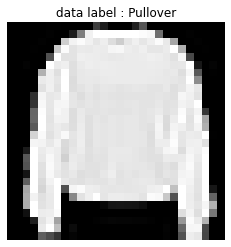

In [14]:
def view_input_img(data, idx, label_map, cmap='gray'):
  plt.imshow(data.data[idx], cmap=cmap)
  plt.title(f"data label : {label_map[data.targets[idx].item()]}")
  plt.axis("off")

view_input_img(train_data, 7, converted_label_map)

### Now let's create the dataloader , to load the data and pass it to training algorithm batch by batch

In [15]:
training_data_loader=DataLoader(
    dataset=train_data,
    batch_size=config.BATCH_SIZE,
    shuffle=True
)

test_data_loader=DataLoader(
    dataset=test_data,
    batch_size=config.BATCH_SIZE,
    shuffle=False     ## generally we don't shuffle the test data, but its upto us, if we want we can do that.
)

In [16]:
## Let's see what each dataloader(test vs train) will contain
for imgs, labels in  training_data_loader:
  print(imgs.shape)
  print(labels.shape)
  break

## This will show that each training batch has [32, 1, 28, 28], Here-
# 32= number of images
# 1= only gray scale no RGB
# 28,28= 28 x 28 matrix present
# and since we have 32 images so we will have 32 labels for them as well.

torch.Size([32, 1, 28, 28])
torch.Size([32])


 couldn't display the image because of : Invalid shape (1, 28, 28) for image data


Displaying image with the help of squeeze



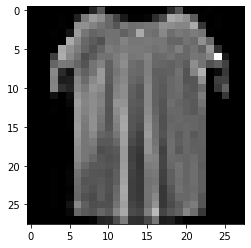

In [17]:
## Now if we want we can't plot imgs[0] because its shape is (1,28,28) and plotlib only takes 28,28 to plot. So in this case we will try to 
## to squeeze the size of the imgs using squeeze().
try:
  plt.imshow(imgs[0])
except Exception as e:
  print(f" couldn't display the image because of : {e}")

print("\n\nDisplaying image with the help of squeeze\n")
## Let's convert the image now using squeeze
plt.imshow(imgs[0].squeeze(), cmap='gray')

In [18]:
## Let's see how squeeze helps us here

print("Image size without squeeze() ", imgs[0].shape)
print("Image size with squeeze() ", imgs[0].squeeze().shape)
print("Image size with unsqueeze() ", imgs[0].unsqueeze(dim=1).shape)

Image size without squeeze()  torch.Size([1, 28, 28])
Image size with squeeze()  torch.Size([28, 28])
Image size with unsqueeze()  torch.Size([1, 1, 28, 28])


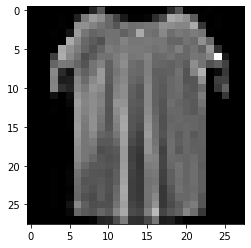

In [19]:
## We can also convert the image into numpy data from torch tensor

numpy_data=imgs[0].squeeze().numpy()
numpy_data
## ploting the numpy image
plt.imshow(numpy_data, cmap='gray')

In [25]:
## Let's create the structure of our model here
class CNN(nn.Module):    ## It is extending Module class from nn
  def __init__(self,in_, out_):
    super(CNN, self).__init__()

    self.conv_pool_01= nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_pool_02= nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Flatten=nn.Flatten()
    self.FC_01=nn.Linear(in_features=16*4*4, out_features=128)
    self.FC_02=nn.Linear(in_features=128, out_features=64)
    self.FC_03=nn.Linear(in_features=64, out_features=out_)

  def forward_pass(self,x):
    x=self.conv_pool_01(x)
    x=self.conv_pool_02(x)
    x=self.Flatten(x)
    x=self.FC_01(x)
    X=self.F.relu(x)
    x=self.FC_02(X)
    X=self.F.relu(x)
    x=self.FC_03(X)
    
    return x



In [26]:
model=CNN(1,10)
print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [27]:
model.conv_pool_02

Sequential(
  (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
model.forward

<bound method _forward_unimplemented of CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)>

In [29]:
## By default is is not runnning on CUDA
next(model.parameters()).is_cuda

False

In [31]:
model.to(config.DEVICE)   ## calling config functions device variable to decide on device

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [33]:
## Now it will be running on CUDA/GPU
next(model.parameters()).is_cuda

True

## Count the number of trainable paramters

In [37]:
def count_params(model):
  model_params= {"Modules":list(), "Parameters":list()}
  total={"trainable":0, "non-trainable":0}

  for name, parameters in model.named_parameters():
    param = parameters.numel()

    if not parameters.requires_grad:
      total['non-trainable'] += param
      continue
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param

  df=pd.DataFrame(model_params)
  df=df.style.set_caption(f" total parameters of the model : {total}")
  return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10
